In [1]:
%matplotlib inline
from SALib.sample import saltelli
from SALib.analyze import sobol as sobol_analyze
from mesa.batchrunner import batch_run
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import clear_output
import pickle
from joblib import Parallel, delayed
from SALib.sample import sobol
from SALib.sample import saltelli
from IPython.display import clear_output
import numpy as np
from itertools import product
import time
import random


from model import SugarscapeG1mt

### RUNNING FOR BASE SETTINGS - NO TAX, NO STAGHUNT

In [21]:
cont_vars = [
    "initial_population",
    "metabolism_min",
    "metabolism_max",
    "endowment_min",
    "endowment_max",
    "vision_min",
    "vision_max",
    # "metabolism_min",
    # "metabolism_max",
]
# cont_bounds = [
#     [50, 500],
#     [0.1, 2.0],
#     [2.0, 3],
#     [0, 10],
#     [15, 30],
#     [1.0, 5.0],
#     [5.0, 10.0],
#     [0, 10],
#     [15, 30],
# ]

adjusted_bounds = [
    [25, 250], # initial population
    [0.1, 1.0],  # metabolism min
    [1.1, 2.0], # metabolism max
    [0, 5], # endowmnent min
    [8, 20], #endownment max
    [1.0, 3.0], # vision min
    [3.1, 6.0], # vision max
]
problem = {
    "num_vars": len(cont_vars),
    "names": cont_vars,
    "bounds": adjusted_bounds,
}

# ----------------------------------------------------------------------
# Integer variables that need rounding
# ----------------------------------------------------------------------
integer_vars = {
    "initial_population",
    "endowment_min",
    "endowment_max",
    "vision_min",
    "vision_max",
    "metabolism_min",
    "metabolism_max",
}

# ----------------------------------------------------------------------
# Fixed discrete factors – only one option each
# ----------------------------------------------------------------------
discrete_factors = {
    "wealth_tax_system": [0],   # 0 ≙ "none"
    "income_tax_system": [0],   # 0 ≙ "none"
    "enable_staghunt":   [0],   # OFF
}

wealth_tax_map  = {0: "none", 1: "proportional", 2: "progressive", 3: "degressive"}
income_tax_map  = wealth_tax_map.copy()


In [ ]:
# ----------------------------------------------------------------------
# GSA settings
# ----------------------------------------------------------------------
replicates       = 10        # Replicates should be at least 10
max_steps        = 100      # Max steps per run should be at least 100
distinct_SA      = 512         # N should be 512
second_order     = False    # Set false for our analysis.
measure          = "Gini"       # can switch to "Avg Wealth"

In [23]:
def run_mixed(run_id, params):
    # 1 – round integers
    for name in integer_vars:
        if name in params:
            params[name] = int(round(params[name]))

    # 2 – enforce ordering on min/max pairs
    for lo, hi, caster in [
        ("endowment_min", "endowment_max", int),
        ("vision_min",    "vision_max",    int),
        ("metabolism_min","metabolism_max",float),
    ]:
        lo_val, hi_val = sorted((params[lo], params[hi]))
        params[lo], params[hi] = caster(lo_val), caster(hi_val)

    # 3 – disable staghunt parameters
    params["enable_staghunt"] = False
    params["p_copy"]  = 0.0
    params["p_mutate"] = 0.0

    # 4 – map tax codes to strings (both are “none”)
    params["wealth_tax_system"]  = wealth_tax_map[0]
    params["income_tax_system"]  = income_tax_map[0]

    # 5 – cast remaining floats
    params["flat_rate"]           = float(params.get("flat_rate", 0.0))
    params["income_tax_flat_rate"]= float(params.get("income_tax_flat_rate", 0.0))

    # 6 – run the model
    out = batch_run(
        SugarscapeG1mt,
        parameters=params,
        iterations=1,
        max_steps=max_steps,
        data_collection_period=-1,
        display_progress=False,
    )[0]

    return {
        **params,
        "RunId": run_id,
        "Gini": out["Gini"],
        "Avg Wealth": out["Average Wealth"],
    }

def run_mixed_safe(run_id, rep, params):
    seed = 1 + run_id + rep * 10000
    random.seed(seed)
    np.random.seed(seed)
    return run_mixed(run_id, params)

In [24]:
all_records = []

# Sample the continuous space once
X = sobol.sample(problem, distinct_SA, calc_second_order=second_order)

tasks = []
for run_id, cont_vals in enumerate(X):
    base = dict(zip(problem["names"], cont_vals))

    # inject fixed discrete settings
    base.update({
        "wealth_tax_system": 0,
        "income_tax_system": 0,
        "enable_staghunt":  False,
    })

    for rep in range(replicates):
        tasks.append((run_id, rep, base.copy()))

# parallel evaluation
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(run_mixed_safe)(rid, rep, p) for rid, rep, p in tasks
)

record = {
    "discrete_setting": (0, 0, False),
    "samples": X,
    "results": results,
}
all_records.append(record)

with open("sobol_none_tax_no_staghunt_test.pkl", "wb") as f:
    pickle.dump(record, f)

print(f"Saved sobol_none_tax_no_staghunt_test.pkl with {len(results)} runs")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   49.1s
/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: D

Saved sobol_none_tax_no_staghunt_test.pkl with 288 runs


[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  3.7min finished


                          ST   ST_conf
initial_population  0.044008  0.023302
metabolism_min      0.678466  0.497810
metabolism_max      0.760163  0.499597
endowment_min       1.201574  0.532591
endowment_max       1.175766  0.529781
vision_min          0.947439  0.503403
vision_max          0.821445  0.431908
                          S1   S1_conf
initial_population  0.123066  0.123406
metabolism_min      0.572859  0.386054
metabolism_max      0.568755  0.405291
endowment_min       0.798719  0.414927
endowment_max       0.855389  0.370790
vision_min          0.349629  0.508318
vision_max          0.420908  0.434355
                                            S2   S2_conf
(initial_population, metabolism_min)  0.481882  0.645534
(initial_population, metabolism_max)  0.347950  0.528355
(initial_population, endowment_min)   0.137618  0.732491
(initial_population, endowment_max)   0.199554  0.607059
(initial_population, vision_min)      0.633982  0.498952
(initial_population, vision_max)  

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


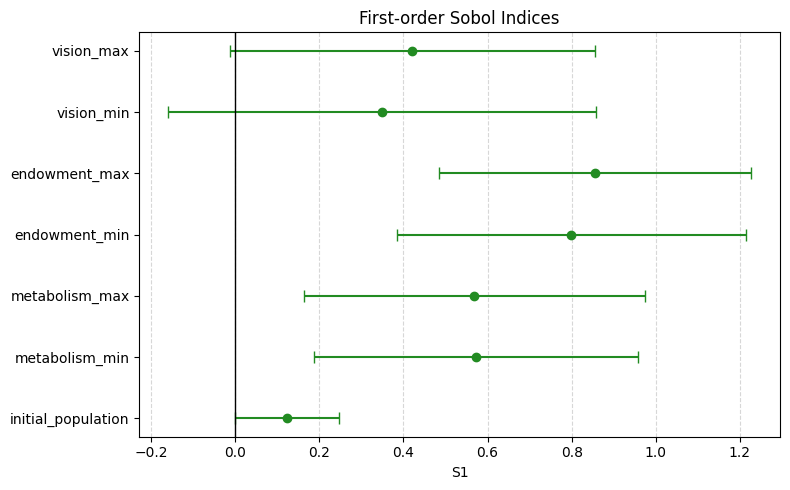

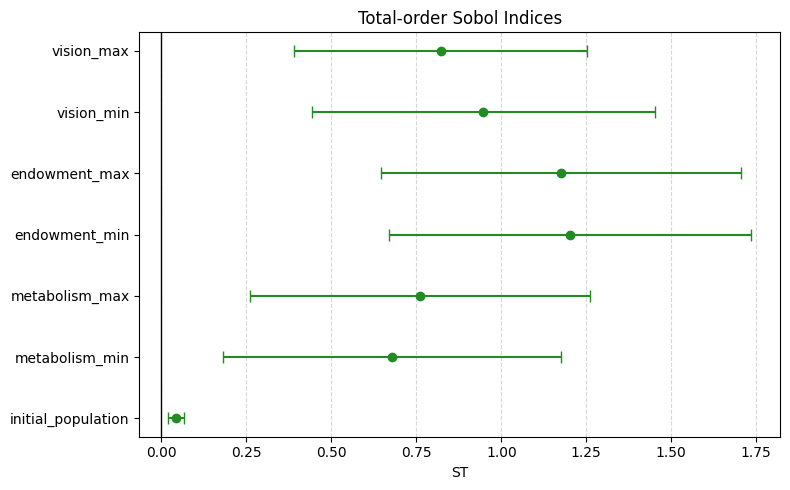

In [29]:
with open("sobol_none_tax_no_staghunt_test.pkl", "rb") as f:
    record = pickle.load(f)

# Unpack inputs
X = record["samples"]
Y = np.array([r["Gini"] for r in record["results"]])

Si = sobol_analyze.analyze(
    problem,
    Y,
    calc_second_order=True,
    print_to_console=True
)

# Plot Sobol indices with error bars
def plot_sobol_indices(Si, index_type='S1', title='Sobol Sensitivity Indices'):
    indices = Si[index_type]
    errors = Si[index_type + '_conf']
    labels = problem['names']

    x = np.arange(len(indices))
    plt.figure(figsize=(10, 5))
    plt.bar(x, indices, yerr=errors, align='center', alpha=0.7, capsize=5)
    plt.xticks(x, labels, rotation=45, ha='right')
    plt.ylabel(index_type)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_sobol_indices_horizontal(Si, index_type='S1', title='First order sensitivity'):
    indices = Si[index_type]
    errors = Si[index_type + '_conf']
    labels = problem['names']

    y = np.arange(len(indices))

    plt.figure(figsize=(8, 5))
    plt.errorbar(indices, y, xerr=errors, fmt='o', color='forestgreen', ecolor='forestgreen', capsize=4)
    plt.axvline(x=0.0, color='black', linewidth=1)
    
    plt.yticks(y, labels)
    plt.xlabel(index_type)
    plt.title(title)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
# First-order (S1)
plot_sobol_indices_horizontal(Si, 'S1', title='First-order Sobol Indices')

# Total-order (ST)
plot_sobol_indices_horizontal(Si, 'ST', title='Total-order Sobol Indices')